# AIDS: exploratory analysis

To export the CSV from the R dataframe available [here](https://github.com/drizopoulos/JM/tree/master/data), I used the following R commands:

    load("aids.rda")
    write.csv(aids, "aids.csv", row.names = TRUE)

Resources on this dataset:

- <https://cran.r-project.org/web/packages/JM/JM.pdf>
- <https://jburos.github.io/example-using-stan-jm/analysis_of_aids_data.html>

In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from tdsurv.utils import kaplan_meier

In [2]:
def safe_binary(true_, false_):
    def f(x):
        if x in (true_, false_):
            return x == true_
        else:
            raise ValueError(f"value '{x}' not in '{true_}', '{false_}'")
    return f

cols = (
    # Patient's identifier; in total there are 467 patients.
    ("patient", int),
    # The time to death or censoring.
    ("Time", float),
    # ?
    ("death", safe_binary("1", "0")),
    # The CD4 cells count.
    ("CD4", float),
    # The time point (in month) at which the CD4 cells count was recorded.
    ("obstime", int),
    # A factor with levels `ddC` denoting zalcitabine and `ddI` denoting didanosine.
    ("drug", safe_binary("ddC", "ddI")),
    # A factor with levels `female` and `male`.
    ("gender", safe_binary("female", "male")),
    # A factor with levels
    # - `AIDS` denoting previous opportunistic infection (AIDS diagnosis) at study entry,
    # - `noAIDS` denoting no previous infection.
    ("prevOI", safe_binary("AIDS", "noAIDS")),
    # A factor with levels
    # - `intolerance` denoting AZT intolerance,
    # - `failure` denoting AZT failure.
    ("AZT", safe_binary("intolerance", "failure")),
    # Start of observation interval.
    ("start", float),
    # End of observation interval.
    ("stop", float),
    # Indicator variable of event at end of observation interval.
    ("event", safe_binary("1", "0")),
)

names, funcs = zip(*cols)

In [3]:
data = list()
with open("../data/aids.csv") as f:
    reader = csv.reader(f)
    cols = next(reader)
    for row in reader:
        data.append([f(elem) for elem, f in zip(row[1:], funcs)])

df = pd.DataFrame(data, columns=names)
print("Number of observations: {:,}".format(len(df)))

Number of observations: 1,405


**Note**: I have verified that the following features are static and do not change over time for any single patient:

- `Time`
- `death`
- `drug`
- `gender`
- `prevOI`
- `AZT`

In [4]:
df.head(10)

,patient,Time,death,CD4,obstime,drug,gender,prevOI,AZT,start,stop,event
0,1,16.97,False,10.677078,0,True,False,True,True,0.0,6.00,False
1,1,16.97,False,8.426150,6,True,False,True,True,6.0,12.00,False
2,1,16.97,False,9.433981,12,True,False,True,True,12.0,16.97,False
3,2,19.00,False,6.324555,0,False,False,False,True,0.0,6.00,False
4,2,19.00,False,8.124038,6,False,False,False,True,6.0,12.00,False
5,2,19.00,False,4.582576,12,False,False,False,True,12.0,18.00,False
6,2,19.00,False,5.000000,18,False,False,False,True,18.0,19.00,False
7,3,18.53,True,3.464102,0,False,True,True,True,0.0,2.00,False
8,3,18.53,True,3.605551,2,False,True,True,True,2.0,6.00,False
9,3,18.53,True,6.164414,6,False,True,True,True,6.0,18.53,True


## Exploratory analysis

### Length of sequences

Number of patients / sequences: 467


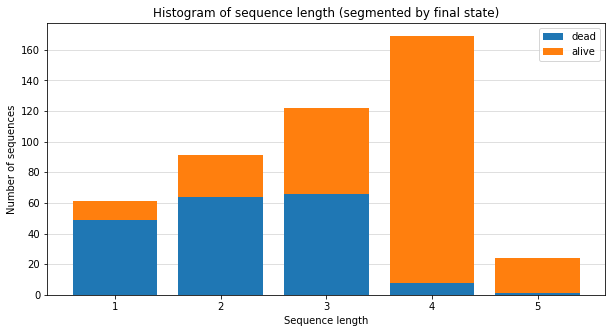

In [5]:
agg = df.groupby("patient")["obstime"]
bins = np.arange(1, 6)

print("Number of patients / sequences: {:,}".format(len(agg)))

fig, ax = plt.subplots(figsize=(10, 5))

cumul = np.zeros(len(bins))
for dead in (True, False):
    vals = df[df.death == dead].groupby("patient")["obstime"].count().values
    cnts, _ = np.histogram(vals, bins=np.arange(1, 7))
    ax.bar(bins, cnts, bottom=cumul, label="dead" if dead else "alive")
    cumul += cnts

ax.set_xticks(bins)
ax.grid(axis="y", alpha=0.5)
ax.set_axisbelow(True)
ax.set_title("Histogram of sequence length (segmented by final state)")
ax.set_xlabel("Sequence length")
ax.set_ylabel("Number of sequences")
ax.legend()

### Time interval between adjacent observations

In principle, patients are observed at month 0, 2, 6 and every 6 months thereafter.

In [6]:
first = list()
second = list()
tail = list()
for seq in agg.apply(list).values:
    deltas = np.diff(seq)
    first.extend(deltas[0:1])
    second.extend(deltas[1:2])
    tail.extend(deltas[2:])

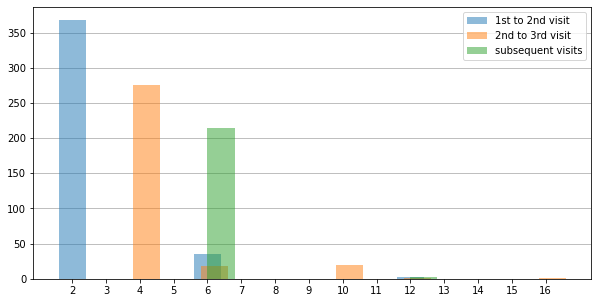

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))

vals, cnts = np.unique(first, return_counts=True)
ax.bar(vals, cnts, alpha=0.5, label="1st to 2nd visit")

vals, cnts = np.unique(second, return_counts=True)
ax.bar(vals+0.2, cnts, alpha=0.5, label="2nd to 3rd visit")

vals, cnts = np.unique(tail, return_counts=True)
ax.bar(vals+0.4, cnts, alpha=0.5, label="subsequent visits")

ax.set_xticks(np.arange(2, 17))
ax.grid(axis="y")
ax.set_axisbelow(True)
ax.legend()

### Distribution of time-to-event

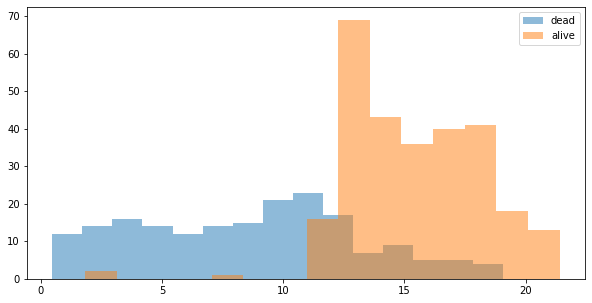

In [8]:
first = df.groupby("patient").first()
fig, ax = plt.subplots(figsize=(10, 5))

for dead in (True, False):
    res = first[first.death == dead]["Time"].values
    ax.hist(res, alpha=0.5, label="dead" if dead else "alive", bins=15)
ax.legend()

### Timelines

In [9]:
agg = df.groupby("patient")
visits = agg["obstime"].apply(list).values
ttes = agg["Time"].first().values
labels = agg["death"].first().values

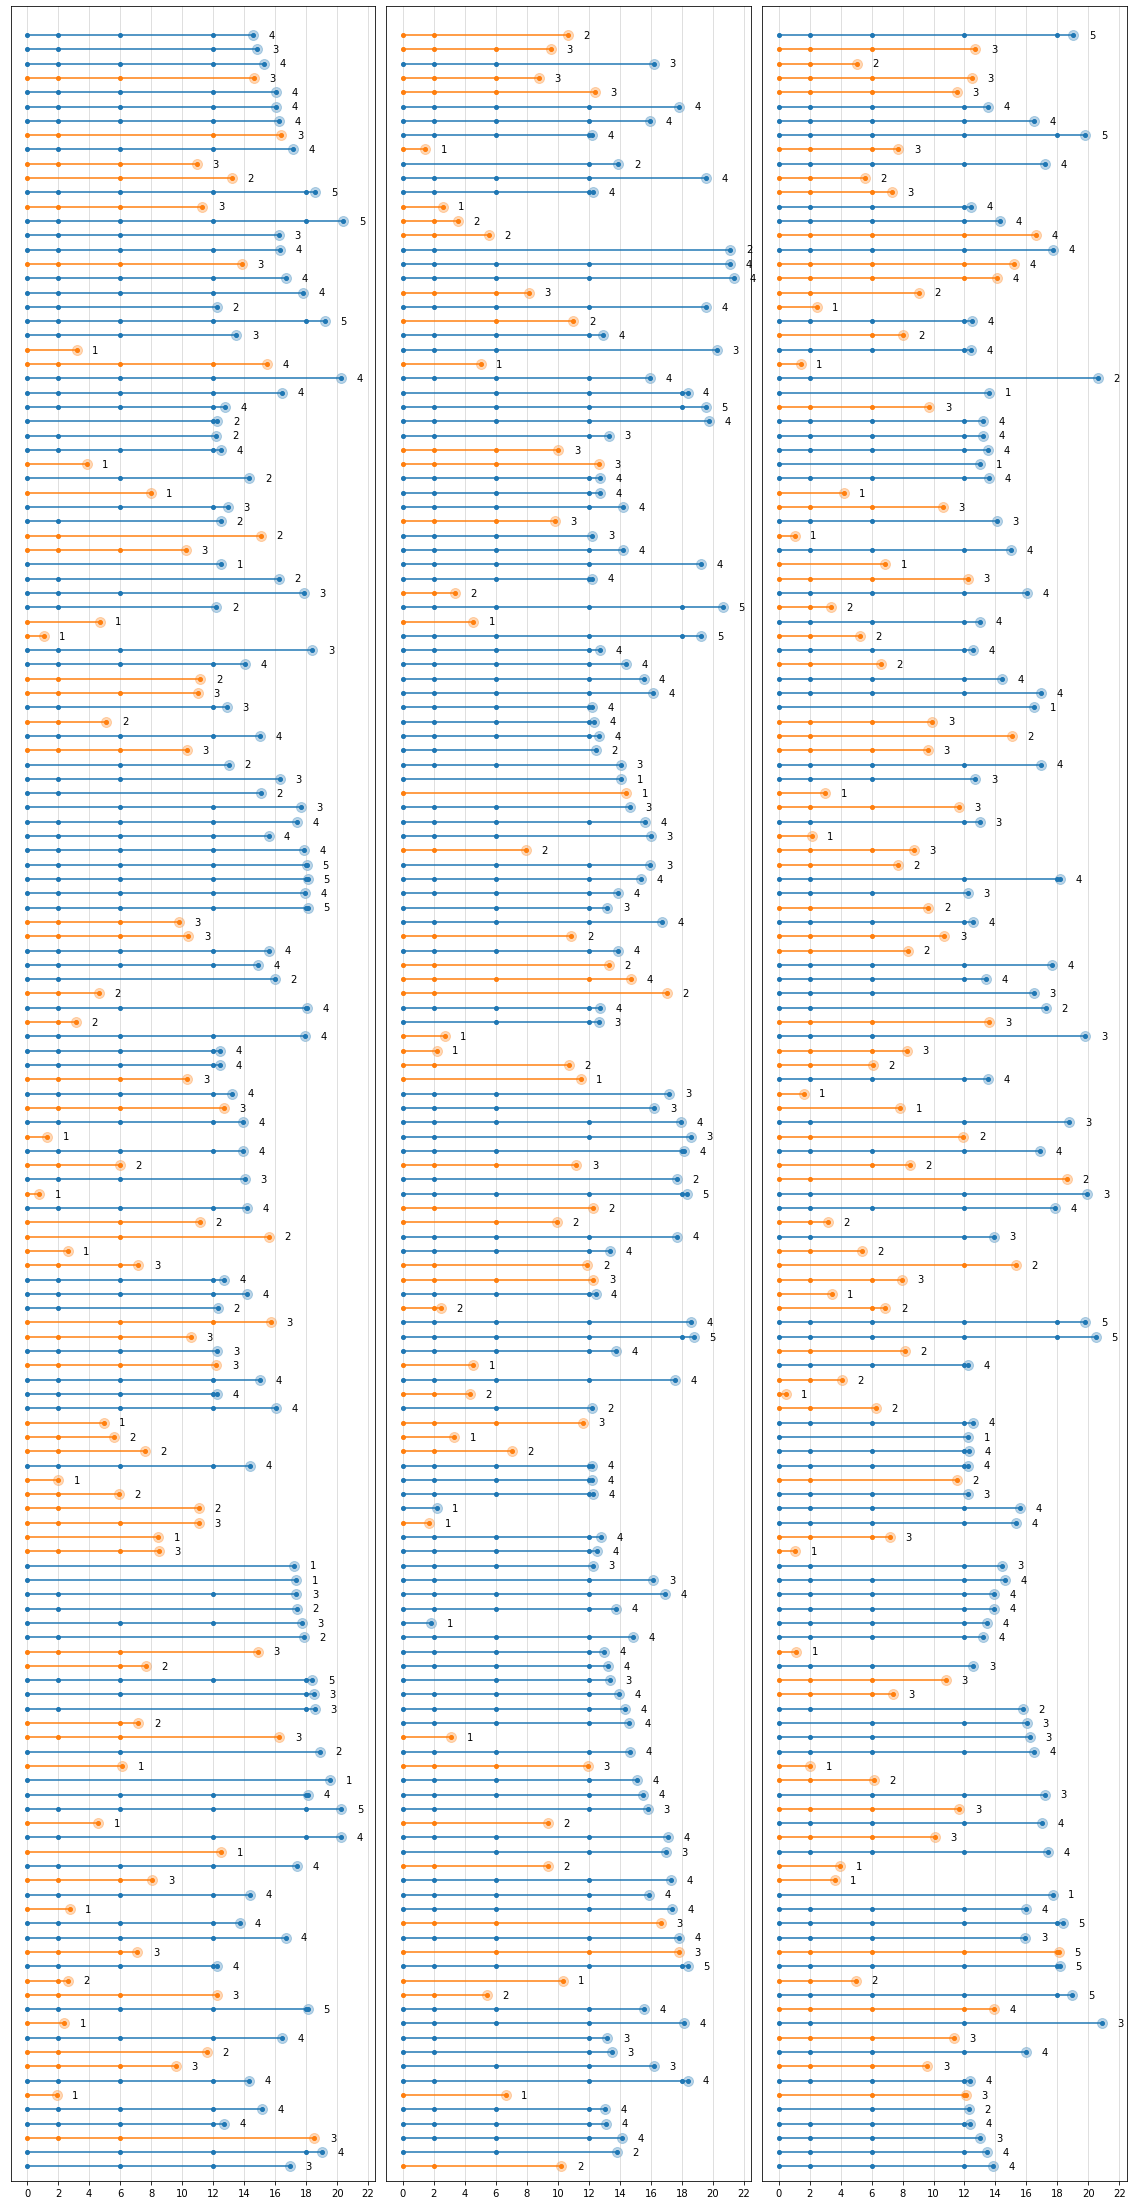

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 40), sharex=True)

for ax, offset in ((ax1, 0), (ax2, 150), (ax3, 300)):
    for i in range(offset, offset + 150):
        color = plt.cm.tab10(int(labels[i]))
        xs = np.append(visits[i], ttes[i])
        ys = (i - offset) * np.ones_like(xs)
        ax.plot(xs, ys, marker="o", ms=4, color=color)
        ax.scatter(ttes[i], i - offset, s=100, alpha=0.3, color=color)
        ax.text(ttes[i] + 1, i - offset, str(len(visits[i])), va="center")
    ax.set_yticks([])
    ax.set_ylim(bottom=-1, top=150 + 1)
    ax.set_xticks(np.arange(0, 23, 2))
    ax.grid(axis="x", alpha=0.5)

fig.subplots_adjust(wspace=0.03)

### Distribution of features

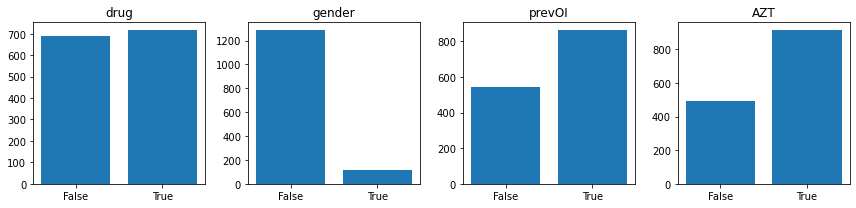

In [11]:
bin_feats = (
    "drug",
    "gender",
    "prevOI",
    "AZT",
)

fig, axs = plt.subplots(ncols=len(bin_feats), figsize=(12, 3))
for ax, col in zip(axs, bin_feats):
    cnt = df[col].value_counts().sort_index()
    idx = np.arange(len(cnt))
    ax.bar(idx, cnt.values)
    ax.set_xticks(idx)
    ax.set_xticklabels(cnt.index)
    ax.set_title(col)
fig.tight_layout()

Text(0.5, 1.0, 'sqrt(CD4)')

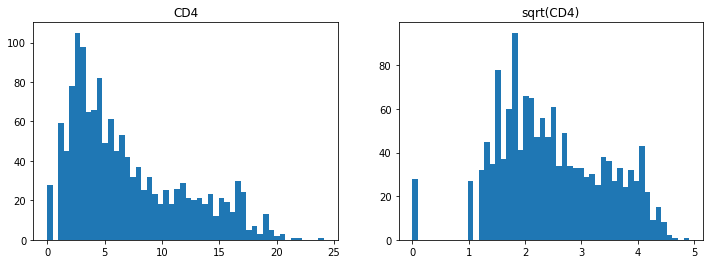

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))

vals = df["CD4"].values

ax1.hist(vals, bins=50)
ax1.set_title("CD4")

ax2.hist(np.sqrt(vals), bins=50)
ax2.set_title("sqrt(CD4)")

## Transforming the data into final form

In [13]:
final = df.copy()

# Add square-root transformed & centered version of `CD4`
vals = np.sqrt(df["CD4"])
final["sqrtCD4"] = vals - vals.mean()

bin_feats = [
    "drug",
    "gender",
    "prevOI",
    "AZT",
]

# Change binary features to floating point indicators.
final[bin_feats] = final[bin_feats].astype(float)

# Transform dataframe into sequences

# Censoring indicator & time-to-event.
agg = final.groupby("patient")["death"]
cs = (~agg.first()).values
ts = agg.count().values - cs.astype(int)

# Sequences in dense format.
agg = final.groupby("patient")
cols = bin_feats + ["sqrtCD4"]
n = len(agg)  # Number of sequences
d = len(cols)  # Number of features
m = agg["drug"].count().max()  # Max. length of sequence
seqs = np.zeros((n, m, d))
for j, col in enumerate(cols):
    for i, seq in enumerate(agg[col].apply(list)):
        k = len(seq)
        seqs[i,:k,j] = seq

Text(0.5, 1.0, 'Kaplan-Meier estimate of survival')

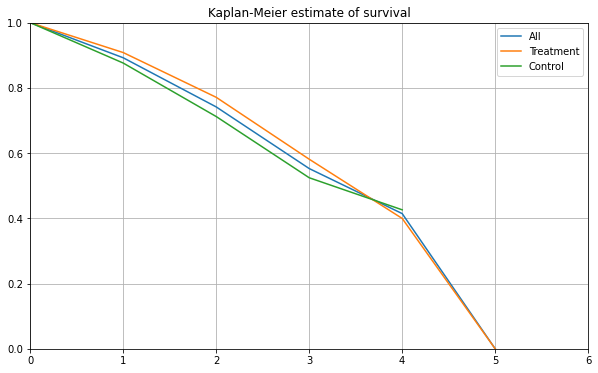

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
    
ys = kaplan_meier(ts, cs)
ax.plot(ys, label="All")

mask = (agg["drug"].first() == 1).values
ys = kaplan_meier(ts[mask], cs[mask])
ax.plot(ys, label="Treatment")
ys = kaplan_meier(ts[~mask], cs[~mask])
ax.plot(ys, label="Control")

ax.set_ylim(ymin=0.0, ymax=1.0)
ax.set_xlim(xmin=0, xmax=6)
ax.grid(axis="both")
ax.legend()
ax.set_title("Kaplan-Meier estimate of survival")

**Note**: there is a single (uncensored) observation at $t = 5$, hence the curve ends at $y = 0$

In [15]:
with open("../data/aids-seqs.pkl", "wb") as f:
    pickle.dump({
        "seqs": seqs,
        "cs": cs,
        "ts": ts,
        "cols": cols,
    }, f)